In [155]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [156]:
data_path = "/Users/sreeharshaankem/MachineLearning/deployment/iris_species_prediction/data/"

# Data Preparation

In [157]:
class IrisDatasetProcessing(Dataset):
    def __init__(self, data_path, feature_cols, target):
        self.feature_cols = feature_cols
        self.target = target
        self.df = pd.read_csv(data_path+"iris.data", 
                              names = self.feature_cols+[self.target])
        self.X, self.y = self.__preprocess()
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        np_subset = self.X[idx]
        np_label = self.y[idx]
        return np_subset, np_label
    
    def __preprocess(self):
        self.df.loc[:, self.target] = self.df.loc[:, self.target].map({"Iris-setosa":0,
                                                                       "Iris-versicolor":1,
                                                                       "Iris-virginica":2})
        self.df.loc[:, self.feature_cols] /= self.df.loc[:, self.feature_cols].max(axis = 0)
        return self.df.loc[:, self.feature_cols].values, self.df.loc[:,self.target].values

In [158]:
dataset = IrisDatasetProcessing(data_path = data_path,
                             feature_cols = ['s_l', 's_w', 'p_l', 'p_w'],
                             target = "species")
train, test = random_split(dataset, lengths = (100, 50))
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)

# Model Building

In [159]:
from torch import nn
from torch.optim import SGD, Adam

In [160]:
model = nn.Sequential(
             nn.Linear(in_features=4, out_features=64),
             nn.ReLU(),
             nn.Linear(in_features=64, out_features=20),
             nn.ReLU(),
             nn.Linear(in_features=20, out_features=3),
             nn.Softmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params = model.parameters(), lr=1e-3)          

In [161]:
epochs = 10000
for epoch in range(epochs):
    for batch_idx , (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(X.float())
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    if epoch%(epochs//10)==0:
        print(epoch, loss.item())

0 1.114733338356018
1000 0.733482837677002
2000 0.5514465570449829
3000 0.5514482259750366
4000 0.5514446496963501
5000 0.8014401197433472
6000 0.5514446496963501
7000 0.5514446496963501
8000 0.5514776110649109
9000 0.5514446496963501


# Get Predictions

In [162]:
test_dataloader = DataLoader(test, batch_size=50, shuffle=False)

for batch_idx, (test_X, test_y) in enumerate(test_dataloader):
    test_y_pred = model(test_X.float())

confidence, pred_class = torch.max(test_y_pred, dim=1)

df_predictions = pd.DataFrame([confidence.data.numpy(), 
                               pred_class.data.numpy()]).T
df_predictions.columns = ["confidence", "predicted"]

# Metrics

In [163]:
df_predictions["true"] = test_y
true_mask = df_predictions["predicted"] == df_predictions["true"]
accuracy = df_predictions.loc[true_mask].shape[0]/df_predictions.shape[0]
print("accuracy : {}".format(accuracy))

accuracy : 0.98


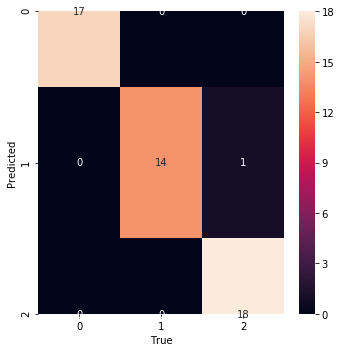

In [164]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

conf = confusion_matrix(df_predictions["true"], df_predictions["predicted"])
fig = plt.figure(figsize = (5,5))
sns.heatmap(conf, annot=True)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.tight_layout()